# 0.项目初始化

In [ ]:
# 克隆仓库
! git init
! git clone https://github.com/atong01/conditional-flow-matching

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'conditional-flow-matching'...
remote: Enumerating objects: 2195, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 2195 (delta 390), reused 309 (delta 309), pack-reused 1665 (from 2)
Receiving objects: 100% (2195/2195), 142.73 MiB | 45.07 MiB/s, done.
Resolving deltas: 100% (1268/1268), done.


In [2]:
cd conditional-flow-matching

/kaggle/working/conditional-flow-matching


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

# 1. 流匹配教程
主要展示两个模型：独立耦合的CFM（I-CFM）和最优路径CFM（OT-CFM）

记$\alpha$ 为噪声分布，通常是高斯分布，$\beta$为真实数据分布

## 常微分方程（ODE）：将一种数据分布转换为另一种数据分布

我们来深入探讨一些基础概念。考虑一个光滑时变向量场 $u : [0, 1] \times \mathbb{R}^d \to \mathbb{R}^d$，该向量场定义了如下常微分方程（ODE）：

$$dx = u_t(x)dt.$$

用 $\phi_t(x)$ 表示满足初始条件 $\phi_0(x)=x$ 的常微分方程解。本质上，$\phi_t(x)$ 描述了点 $x$ 沿向量场 $u$ 从时刻 $0$ 到时刻 $t$ 的传输轨迹。

假设已知分布 $p_0$ 和 $p_1$，则可建立两者之间的转换过程。积分映射 $\phi_t$ 会诱导出 $p_0$ 和 $p_1$ 之间的前推测度 $p_t:=[\phi_t]_\#(p_0)$。该测度刻画了服从分布 $p_0$ 的点 $x$ 经向量场 $u$ 从时刻 $0$ 传输到时刻 $t$ 后的密度特征。

时变密度 $p_t$ 可表示为函数 $p:[0,1]\times\mathbb{R}^d\to\mathbb{R}$，其满足初始条件 $\phi_0(x)=x$ 以及著名的连续性方程：

$$
\frac{\partial p}{\partial t}=-\nabla\cdot(p_t u_t)
$$

## 向量场回归：一个难处理的损失函数

假设我们已经知道了概率路径 $p_t(x)$ 及其对应的生成向量场 $u_t(x)$，并且 conveniently 地假设 $p_t(x)$ 是容易采样的。

如果 $v_\theta(\cdot,\cdot):[0,1]\times\mathbb{R}^d\to\mathbb{R}^d$ 是一个依赖于时间的向量场，通过神经网络参数化（权重为 $\theta$），我们的目标是使用**流匹配（FM）目标**将 $v_\theta$ 回归到 $u$：

$$
\mathcal{L}_{\text{FM}}(\theta) := \mathbb{E}_{t\sim [0,1],x\sim p_t(x)} \| v_\theta(t, x) - u_t(x) \|^2.
$$

这个目标函数允许我们通过在不同时间点 $t$ 和从 $p_t(x)$ 中采样的点 $x$ 上最小化期望平方范数差，来将 $v_\theta$ 与 $u$ 对齐。然后，我们可以通过在上述 ODE 中使用 $v_\theta$ 来代替 $u$ 来生成数据。然而，对于一般的源分布和目标分布，这个目标函数变得难以处理，因为 $p_t(x)$ 和 $u_t$ 是未知的通用函数。


## 条件流匹配

上述方法的主要局限在于其难以处理，因为我们不知道 $u_t$ 和 $p_t$。为了使目标可行，我们选择一种更易处理的策略，通过指定概率路径和向量场的形式。

这里，我们假设概率路径 $p_t(x)$ 采用包含**条件概率路径 $p_t(x|z)$** 的混合形式，其中 $z$ 作为条件变量：

$$
p_t(x) := \int p_t(x | z) q(z)\, dz.
$$

$q(z)$ 表示条件变量的分布。此外，我们希望 $p_1(x | z)$ 是一个集中在 $z$ 附近的分布。对于条件概率路径 $p_t(x|z)$ 的一个自然设计选择是采用高斯分布，表示为 $p_t(x | z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$。在我们的论文中，我们选择以源样本和目标样本的元组 $z = (x_0, x_1) \sim \alpha \otimes \beta$ 作为条件。我们将 $\mu_t$ 定义为 $x_0$ 和 $x_1$ 之间的线性插值（关于时间，即 $\mu_t(x_0, x_1) = t x_1 + (1 - t) x_0$），并将标准差 $\sigma_t = \sigma>0$ 设为一个常数浮点数。选择这种特定 $\mu_t$ 的动机在于最优传输理论，我们将在后面详细说明。值得注意的是，如 (Lipman et al, 2023) 中强调的，也存在其他可能的选择。

遗憾的是，由于公式中的积分，直接从无条件概率路径 $p_t(x)$ 采样受到阻碍。取而代之的是，我们将从条件概率路径 $p_t(x|z)$ 中采样，并在后面展示我们可以构建一个条件流匹配损失，该损失与其无条件对应物共享许多优点。


In [4]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

## 构建容许向量场

我们基于以下假设进行推导：用于定义无条件概率路径的条件概率路径 $p_t(x|z)$ 是由某个条件向量场 $u_t(x|z)$ 生成的。

接下来的挑战是定义一个无条件向量场 $u_t(x)$，当它与 $p_t(x)$ 配对时，能够满足连续性方程。

基于 [(Lipman et al., Theorem 1)](https://arxiv.org/abs/2210.02747) 的改进定理，我们可以证明这样的向量场存在，如 [(Tong et al., Theorem 3.1)](https://arxiv.org/abs/2302.00482) 所示。受 $p_t$ 结构的内在影响，$u_t$ 采用包含条件向量场 $u_t(x | z)$ 的混合形式。形式上，它由下式定义：

$$
u_t(x) := \mathbb{E}_{q(z)} \frac{u_t(x | z) p_t(x | z)}{p_t(x)}.
$$

这个公式确保了 $u_t$ 在与 $p_t(x)$ 关联时满足连续性方程的理论要求。然而，积分引入的复杂性再次使得上述 $u_t(x)$ 在实际中难以直接使用。因此，我们转而依赖其条件对应项 $u_t(x|z)$。

在条件概率路径 $p_t(x|z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$ 为高斯分布的具体情况下，条件向量场 $u_t(x|z)$ 具有唯一的闭式表达式：

$$
u_t(x|x_0, x_1) = \frac{\sigma_t'}{\sigma_t} (x - \mu_t) + \mu_t',
$$

由于 $\mu_t(x_0, x_1) = t x_1 + (1-t) x_0$ 且 $\sigma_t = \sigma>0$ 为常数，条件向量场 $u_t(x∣z)$ 可进一步简化为：

$$
u_t(x|x_0, x_1) = x_1 - x_0.
$$

In [5]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

如前所述，无条件向量场 $u_t(x)$ 和概率路径 $p_t(x)$ 的计算是难以处理的。然而，鉴于其高斯特性，我们可以轻松地从条件概率路径 $p_t(x|z)$ 中采样，并利用现有的闭式表达式计算条件向量场 $u_t(x|z)$。因此，我们选择让网络 $v_\theta$ 回归到$\textit{条件向量场}$ $u_t(x|z)$，而不是无条件向量场。条件流匹配损失因此定义为：

$$
\mathcal{L}_{\text{CFM}}(\theta) := \mathbb{E}_{t, q(z), p_t(x | z)} \|v_\theta(t, x) - u_t(x | z)\|^2.
$$

值得注意的是，该损失中的期望反映了 $u_t(x)$ 的定义。此外，该损失等于无条件流匹配损失，仅相差一个与 $\theta$ 无关的常数（定理 2, [(Lipman et al.)](https://arxiv.org/abs/2210.02747)，定理 3.2 [(Tong et al.)](https://arxiv.org/abs/2302.00482)）。

需要指出的是，所构建的边缘概率路径 $p_t(x)$ 和推导出的向量场 $u_t(x)$ 并不包含满足 ODE 部分定义的连续性方程的所有概率路径和向量场。

## 选择 $q$

另一个需要考虑的关键因素是隐变量分布 $q(z)$ 的选择。目前我们采用一种简单的方法，考虑噪声和真实数据元组上的均匀分布，即 $q(z) = q(x_0,x_1) = q(x_0) q(x_1)$。我们将在后面看到 $q$ 的不同选择。

注：隐分布（latent distribution）即条件变量$z$的分布

In [6]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

2025-11-05 03:23:22.989870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762313003.162448      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762313003.217249      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

5000: loss 8.482 time 32.69


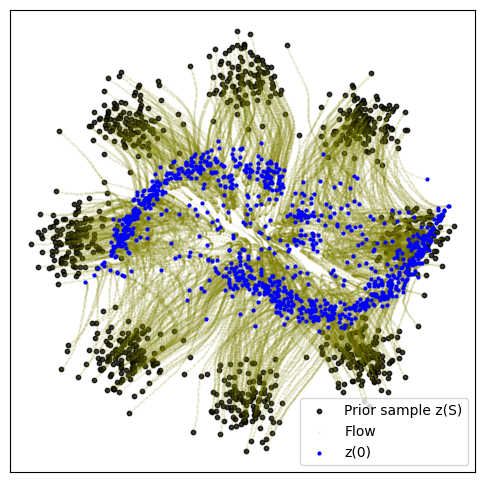

10000: loss 7.898 time 36.05


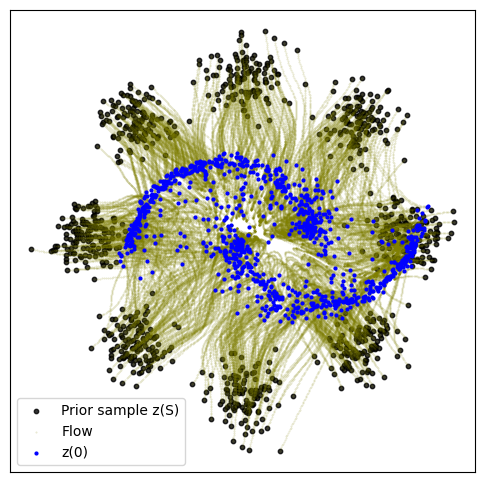

15000: loss 7.798 time 34.01


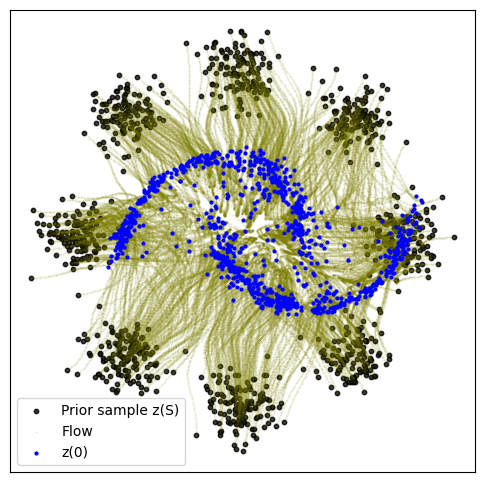

20000: loss 8.102 time 33.41


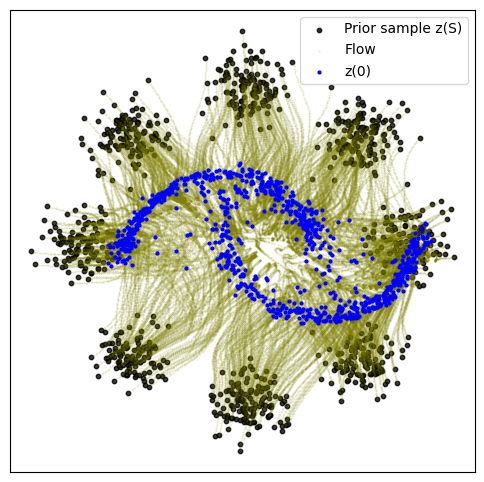

CPU times: user 4min 27s, sys: 904 ms, total: 4min 28s
Wall time: 2min 17s


In [7]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

正如我们所见，上述方法在生成样本方面效果很好。然而，路径相当弯曲。这些路径效率不高，会导致比更直的路径更长的推理时间。为了获得更直的路径，我们可以选择不同的分布 $q$。

# 最优传输

为了获得更直的路径，我们可以利用最优传输（OT）理论。实际上，正如 [(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567) 中所讨论的，OT问题可以重新表述为最小路径长度问题。因此，我们希望利用这一特性来产生更直的流，从而实现更快的推理过程。

OT问题旨在最小化两个分布之间的位移成本。形式上，令 $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ 和 $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$ 分别表示源分布和目标分布（即它们是狄拉克函数的和）。

最优传输基于两个关键概念：$\textbf{传输}$ 和 $\textbf{成本}$。让我们深入探讨第一个概念。

为了将一个分布传输到另一个分布，我们检查它们的概率表示。分布 $\alpha$ 和 $\beta$ 是具有均匀权重的狄拉克函数之和。这意味着我们可以将它们表示为位置和概率权重的元组（即 $(x_i, \frac1n)_{i=1}^n$ 和 $(z_j, \frac1n)_{j=1}^n$）。要将 $\alpha$ 移向 $\beta$，任务是将每个样本质量 $\frac1n$ 从 $\alpha$ 传输到 $\beta$ 样本。

为了形式化这一概念，我们引入一个传输矩阵，记为 $\Pi$。$\Pi$ 的每一行对应一个源样本，每一列代表一个目标样本。因此，元素 $\Pi_{ij}$ 表示从 $x_i$ 传输到 $z_j$ 的质量量。

为了确保每个 $\alpha$ 样本都被传输到 $\beta$（反之亦然），传输计划 $\Pi$ 必须满足以下约束：$\sum_j \Pi_{ij} = a_i = \frac1n$ 和 $\sum_i \Pi_{ij} = b_j = \frac1n$。这意味着每个样本的质量 $\frac1n$ 都已移动到另一个分布。这些约束保证了传输过程中的质量守恒。

在建立了传输分布的方法后，让我们深入探讨 $\textbf{位移成本}$ 的概念。

在旨在最小化从 $\alpha$ 到 $\beta$ 的距离成本的最优传输背景下，我们需要一个距离的概念。这就是为什么我们评估源分布和目标分布的支撑集之间的距离（即 $\alpha$ 的 $(x_i)_{i=1}^n$ 和 $\beta$ 的 $(z_j)_{j=1}^n$）。这涉及引入一个基础成本矩阵 $C$，其中 $C_{ij} = \|x_i - z_j\|$ 测量支撑点 $x_i$ 和 $z_j$ 之间的距离。

将所有组件结合在一起，将 $\alpha$ 移动到 $\beta$ 的成本由 $\sum_{ij} \Pi_{ij} C_{ij} = \langle \Pi, C \rangle_F$ 给出。

由于OT问题寻求最小位移成本，我们解决以下问题：
$$\Pi^\star=\text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle.$$

其中 $U(\alpha, \beta)$ 表示满足质量守恒约束的容许传输计划集合。

因此，为了产生更快的推理过程，**我们选择隐分布 $q(x_0, x_1) = \Pi(x_0, x_1)$。**

遗憾的是，对于大规模数据集，计算 $\Pi$ 是不可行的，我们转而依赖小批量近似（关于小批量OT及其耦合的参考请见 [(Fatras et al.)](https://proceedings.mlr.press/v108/fatras20a.html)）。尽管如此，如下所示，小批量OT耦合仍能带来良好的性能，建议参考笔记本 **minibatch_OT** 来深入了解关于小批量OT的详细讨论。

注:由于本笔记的样本量较小,使用的是全样本的OT-CFM,不是小批量近似. 可以看出OT-CFM的运行时间比上面的I-CFM长,但是路径更加直. 因为比I-CFM多了一步OT Plan采样.

5000: loss 0.132 time 125.41


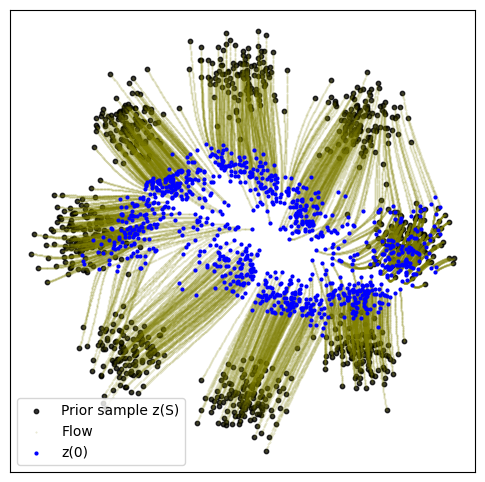

10000: loss 0.112 time 129.61


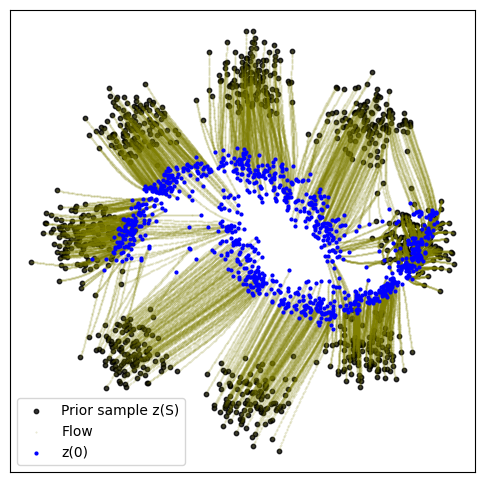

15000: loss 0.092 time 126.98


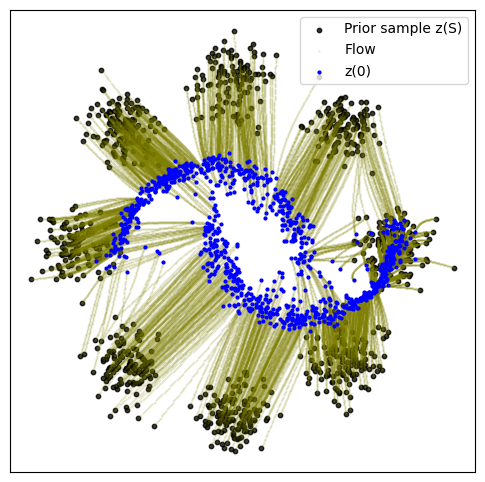

20000: loss 0.101 time 129.78


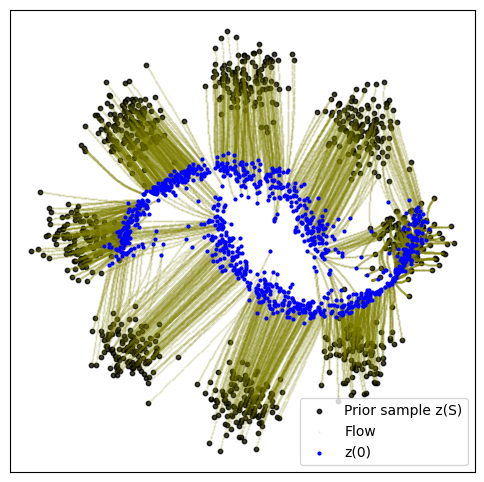

CPU times: user 15min 34s, sys: 1.88 s, total: 15min 36s
Wall time: 8min 35s


In [8]:
%%time
from torchcfm.optimal_transport import OTPlanSampler

ot_sampler = OTPlanSampler(method="exact")
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    # Draw samples from OT plan
    x0, x1 = ot_sampler.sample_plan(x0, x1)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())